# Derivativos de Taxa de Juros
## Modelo de Kalotay-Williams-Fabozzi

Renato Mori, Uirá Caiado. 19 de Junho, 2016

**Resumo**

*Neste projeto vamos implementar um modelo de um fator chamado [Kalotay-Williams-Fabozzi](https://en.wikipedia.org/wiki/Short-rate_model#One-factor_short-rate_models), onde apenas um único fator estocástico - a taxa de juros instantânea - determina a evolução de toda estrutura a termo da taxa de juros. Vamos descrever brevemente o modelo, detalhar sua implementação, estimar seus parâmetros e demonstrar sua utilização para precificação de alguns títulos que sejam possíveis de compara com preços de mercado.*

## 1. Introdução

Nesta sessão vamos introduzir o modelo discutido neste trabalho e descrever o problema que será abordado aqui.


### 1.1. Modelagem da Curva de Juros

Como colocado por Fabozzi, a Taxa de Juros frequentemente é modelada usando equações diferenciais estocásticas ([SDEs](https://en.wikipedia.org/wiki/Stochastic_differential_equation) é a abreviação em inglês). Os modelos mais comumente utilizados são os modelos de um ou dois fatores (estocástios), sendo que o de um usa uma SDE para representar a taxa de juros de curto prazo e a segunda representa tanto a taxa de curto como a de longo prazo. Na dinâmica escolhida para o modelo que deve ser refletidas as características desejadas para a curva, como reversão a média e volatilidade dependente do nível da taxa.

Existe duas abordagens para na utilizaçtão de equações estocásticas na modelagem da curva a termo de juros: modelos de equilibrio e modelos de não arbitragem, sendo que ambos são usados para precificar *Bonds* e derivativos sobre taxa de juros.

Modelos de equilíbrio começam com uma SDE e desenvolvem uma estrutura que não necessariamente correspondem aos preços observados no mercado. Alguns exemplos de modelos desta classe são o Vasicek, Brenna and Schwartz e o Cox, Ingersoll and Ross.

Os modelos de não arbitragem também utilizam uma SDE, porém usam os preços de mercado para gerar os caminhos possíveis para taxa de juros. Esta estrutura segue as características impostas pela SDE as taxas de juros encontradas, quando usadas para precificar um bond qualquer, resultam na mesma taxa de juros observada no mercado. Exemplos são o Ho and Lee, Black, Derman and Toy e o Hull and White.

Os modelos de não arbitragem geralmente são escolhidos para precificação de Bonds e derivativos pois garantem que as taxas atuais correspondam ao mercado. Este trabalgho explorará um modelo de não arbitragem chamado Kalotay-Williams-Fabozzi.

### 1.2. Modelo Kalotay-Williams-Fabozzi

O modelo Kalotay-Williams-Fabozzi (KWF) assume que as mudanças na taxa de juros de curto prazo segue um certo [processo estocástico](https://en.wikipedia.org/wiki/Stochastic_process) que pode ser descrito pela seguinte SDE:

$$ \mathrm{d} \ln \left (  r(t) \right ) = \theta(t) \mathrm{d} t + \sigma\mathrm{d}Z$$

Onde $Z$ é um processo de [Wiener](https://en.wikipedia.org/wiki/Wiener_process), $\theta$ é o *drift* do processo e $\sigma$ é a volatilidade da primeira diferença das taxas de curto prazo.  Como o que a equação descreve é a dinâmica do **logarítimo natural** de taxa $r$; e $W$ tem distribuição normal, o $\ln(r)$ terá distribuição normal e o $r$, log normal. Desta maneira, embora $\ln(r)$ possa assumir valores negativos, $r$ não assumirá.

No trabalho original em que o modelo KWF foi apresentado, os autores não incluiram explicitamente o *drift* na dinâmica do processo na modelagem e, por tanto, também não utilizaremos ele aqui. Assim, assumindo $\theta=0$, integrando ambos os lados da SDE, chamando $\ln(r)$ de $f(t)$ e sabendo que $W_t - W_s = W_{t-s}$, ficamos com:

\begin{equation}
    \begin{aligned}
    \int_{t}^{T}{\mathrm{d} f(t)} &=  \sigma \int_{t}^{T}{\mathrm{d}W_{t}} \\
    f(T) - f(t) &= \sigma \left (  W_{T} - W_{t} \right ) \\
    \ln \left (  r(T) \right ) - \ln \left (  r(t) \right ) &= \sigma \left (  W_{T} - W_{t} \right )\\
    r(T) &= r(t) \cdot e^{\sigma \cdot W_{T-t}}
    \end{aligned}
\end{equation}

Na proxima seção, discretizaremos este processo e implementaremos este modelo.

## 2. Implementando o Modelo

Nesta sessão detalharemos e implementaremos o modelo utilizando como referência o artigo original e calibraremos ele para que bata com os dados de mercado.

### 2.1. Aproximação da SDE por Árvore Binomial

As equações diferenciais estocásticas podem ter sua solução aproximada numericamente utilizando uma árvore binomial. Este método assume que a taxa de juros de curto prazo pode assumir apenas dois valores no período seguinte da discretização, $r_{u}$ ou $r_{d}$, onde $r_{u} > r_{d}$. Como cada nó da árvore dá origem à dois novos nós, a medida que se aumenta os passos de discretização, o número de nós aumenta rapidamente, resultando em uma árvore com $2^{\,\,passos-1}$ nós no último passo da árvore, cado um representando uma evolução específica da taxa.

Para evitar este crescimento exponencial, é imposto ao modelo que a árvore seja recombinante, ou seja, um movimento de subida seguido por uma queda resulta no mesmo nó de uma queda seguida de uma alta. Isto reduz a árvore para a ter a mesma quantidade de nós que tem de passos no último estágio. Um movimento de alta na taxa de juros tem probabilidade $q$ de ocorrer, enquanto um de queda tem probabilidade de $1 - q$. Combinando cada nó com sua respectiva probabilidade, esta árvore é eqivalente à árvore não recombinante. 

Utilizaremos probabilidade de $q=0.5$ para garantir a neutralidade a risco na solução da SDE. É importante frisar que isso não implica na probabilidade real da taxa de juros cair. A probabilidade $q$ representa apenas a probabilidade no mundo [*neutro a risco*](https://en.wikipedia.org/wiki/Risk-neutral_measure). Abaixo, vamos testar a estrtutura criada para representar uma árvore binomial. Como será demonstrado, o total de nós criados é equivalente a $\sum_{i=1}^{n+1}{i}$, onde $n$ é a quantidade de passos.

In [73]:
# bibliotecas necessarias
import numpy as np
import math
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt

In [5]:
import time
import binomial_tree; reload(binomial_tree);

def foo(i):
    f_start = time.time()
    x = binomial_tree.BinomialTree(i)
    x._go_foward(i)
    i_rtn = len(x.set_of_nodes)
    return i_rtn, time.time() - f_start

print "Tempo para inicar toda a arvore: "
for i in [10, 100, 250, 500, 1000]:
    # mais de 1000 nodes trava
    i_nodes, f_time = foo(i)
    print u"- Com {} passos: Criados {:0,.0f} nós em {:.2f} segundos".format(i, i_nodes, f_time)

Tempo para inicar toda a arvore: 
- Com 10 passos: Criados 66 nós em 0.00 segundos
- Com 100 passos: Criados 5,151 nós em 0.10 segundos
- Com 250 passos: Criados 31,626 nós em 0.51 segundos
- Com 500 passos: Criados 125,751 nós em 2.24 segundos
- Com 1000 passos: Criados 501,501 nós em 10.10 segundos


A propriedade da recombinação pode ser visualizada no diagrama abaixo:

In [6]:
import binomial_tree; reload(binomial_tree);
x = binomial_tree.BinomialTree(12)
x._go_foward(12)
print 'Primeiros passos da arvore criada:\n========================================\n\n'
print x

Primeiros passos da arvore criada:


								UUUUUUUU
							UUUUUUU	
						UUUUUU		DUUUUUUU
					UUUUU		DUUUUUU	
				UUUU		DUUUUU		DDUUUUUU
			UUU		DUUUU		DDUUUUU	
		UU		DUUU		DDUUUU		DDDUUUUU
	U		DUU		DDUUU		DDDUUUU	
_		DU		DDUU		DDDUUU		DDDDUUUU
	D		DDU		DDDUU		DDDDUUU	
		DD		DDDU		DDDDUU		DDDDDUUU
			DDD		DDDDU		DDDDDUU	
				DDDD		DDDDDU		DDDDDDUU
					DDDDD		DDDDDDU	
						DDDDDD		DDDDDDDU
							DDDDDDD	
								DDDDDDDD

Plotted 8 from 12 steps


### 2.2. Discretização o Modelo

Como pode ser visto no diagrama acima, a taxa $r_U$ está sempre $2$ nós distante da taxa $r_D$  (há um nó vazio entre elas). Como a dinâmica proposta é dinâmica $r(T) = r(t) \cdot e^{\sigma \cdot W_{T-t}}$, considerando que já possuímos o nó mais baixo, se utilizarmos $r_D$ como *proxy*, a taxa logo acima dela será $r_U=r_D\, e ^{\,2\sigma}$, onde $\sigma$ é a volatilidade constante da taxa [*forward*](http://www.investopedia.com/terms/f/forwardrate.asp) de um ano.

```
TODO: melhorar esse boloco. Preciso explicar ajuste proposto pelo Renato
```

Assim o modelo segue de maneira bem direta: itera os nós mais baixos de maneira que, ao atualizar os nós acima no mesmo passo e trazer o valor de um bond hipotético a valor presente, o preço seja seja markoviado, ou seja, que $E\,[\,X_{t+1}] = X_t$. A iteração foi feita chutando valores ao redor de um ponto inicial (o juros de mercado) e minimizando os [erros quadrados](http://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.leastsq.html) entre os preços encontrados pelo modelo e o preço observado no mercado.

In [7]:
# dados originais do paper
import binomial_tree; reload(binomial_tree)
l_txindicativa = [0.035, 0.04, 0.045]
l_prazo = [1., 2., 3.]

my_tree = binomial_tree.KWFTree(l_txindicativa, l_prazo)
my_tree.fit_foward_curve(f_sigma=0.1, f_faceval=100.)
print my_tree

			UUU
		UU	
	U		DUU
_		DU	
	D		DDU
		DD	
			DDD



In [8]:
my_tree.get_description()

                 cupon     valor     taxa      prazo     venc      sigma     
_                 0.00   100.000     3.500    1.0000    0.0000    0.0000
D                 4.50    99.926     4.074    1.0000    1.0000   10.0000
U                 4.50    98.074     4.976    1.0000    1.0000   10.0000
DD                4.50    99.972     4.530    1.0000    2.0000   10.0000
DU                4.50    99.022     5.532    1.0000    2.0000   10.0000
UU                4.50    97.886     6.757    1.0000    2.0000   10.0000
DDD               4.50   100.000     0.000    1.0000    3.0000    0.0000
DDU               4.50   100.000     0.000    1.0000    3.0000    0.0000
DUU               4.50   100.000     0.000    1.0000    3.0000    0.0000
UUU               4.50   100.000     0.000    1.0000    3.0000    0.0000


Onde as taxas nos pontos D, DD e DDD foram obtidas por iteração. Utilizando a curva obtida acima, pode-se então calcular o preço de um bond hipotético que vale $\$\,100$ no vencimento e paga cupons de $\$\,5.25$ por ano.

In [9]:
import instruments; reload(instruments);
bond_example = instruments.Bond(f_face_value=100., f_cupon=5.25)
print "Preço do Bond: {:.2f}".format(bond_example.get_current_value(my_tree, 3))

Preço do Bond: 102.07


Abaixo realizamos o mesmo procedimento para fitar uma curva de LTNs. Utilizamos como referência os preços dos bonds no dia $13$ de Junho, que foram levantados pelo site da [ANBIMA](http://portal.anbima.com.br/Pages/home.aspx). Utilizamos $12$ vértices no total. O juros de um nó para outro e a volatilidade foram ajustados ao vencimento de cada ponto. Primeiro, vamos checar quanto temo a estrtutura criada leva para se ajustar aos vértices passados, utilizando bons hipotéticos com cupons nos juros de cada vértice.

In [10]:
import binomial_tree; reload(binomial_tree)
import pandas as pd
# definindo parametros
l_txindicativa = [14.152, 14.0265, 13.7596, 13.4663, 13.1995,
                  12.9729, 12.8001, 12.7250, 12.6541, 12.5649,
                  12.5653, 12.6005]
l_prazo = [9., 74., 136., 199., 260., 324., 385., 446., 509, 635., 758., 888.]
l_txindicativa = [x/100. for x in l_txindicativa]

In [11]:
# testa tempo
def foo():
    my_tree = binomial_tree.KWFTree([x for x in l_txindicativa],
                                    [x/252. for x in l_prazo])
    my_tree.fit_foward_curve(f_sigma=0.1)
    
%timeit foo()

1 loop, best of 3: 603 ms per loop


In [66]:
#cria arvore
import binomial_tree; reload(binomial_tree)
my_tree = binomial_tree.KWFTree([x for x in l_txindicativa],
                                [x/252. for x in l_prazo])
my_tree.fit_foward_curve(f_sigma=0.1, f_faceval=1000.)

In [25]:
my_tree.get_description()

                 cupon     valor     taxa      prazo     venc      sigma     
_                 0.00  1000.000    14.152    0.0357    0.0000    0.0000
D                 4.25  1032.765    12.622    0.0357    0.0357   10.0000
U                 4.25   968.216    15.417    0.0357    0.0357   10.0000
DD               31.08  1062.316    10.907    0.2579    0.2937   10.0000
DU               31.08  1005.360    13.321    0.2579    0.2937   10.0000
UU               31.08   941.862    16.271    0.2579    0.2937   10.0000
DDD              29.63  1084.957     9.373    0.2460    0.5397   10.0000
DDU              29.63  1035.224    11.448    0.2460    0.5397   10.0000
DUU              29.63   979.065    13.983    0.2460    0.5397   10.0000
UUU              29.63   916.580    17.079    0.2460    0.5397   10.0000
DDDD             30.11  1100.834     8.103    0.2500    0.7897   10.0000
...


Com a curva ajustada, vamos calcular os preços atuais de zeros-cupons que tem principal de $\$\,1.000$ para cada um dos vértices e comparar com os seguintes PUs:

In [26]:
for f_r, f_prazo in zip(l_txindicativa, l_prazo):
    f_aux = 1000./(1+f_r)**(f_prazo/252.)
    print "PU do prazo {:4.0f}: {:.2f}".format(f_prazo, f_aux)

PU do prazo    9: 995.28
PU do prazo   74: 962.19
PU do prazo  136: 932.79
PU do prazo  199: 905.05
PU do prazo  260: 879.93
PU do prazo  324: 854.85
PU do prazo  385: 831.92
PU do prazo  446: 808.97
PU do prazo  509: 786.10
PU do prazo  635: 742.12
PU do prazo  758: 700.45
PU do prazo  888: 658.24


In [27]:
# calcula precos dos bonds
import instruments; reload(instruments);
bond_example = instruments.Bond(f_face_value=1000., f_cupon=0.)
for i in xrange(1, 13):
    print "{}: {:5.2f}".format(i, bond_example.get_current_value(my_tree, i_steps=i))

1: 995.28
2: 962.19
3: 932.81
4: 905.13
5: 880.12
6: 855.17
7: 832.39
8: 809.52
9: 786.74
10: 742.89
11: 701.18
12: 658.79


Como observado, os valores ficam muito próximos, porém ainda não condizem com os valores de mercado. Para garantir que o modelo convirja para os preços desejados, ao invés de calcularmos um bond hipotético que paga cupons para fazermos a aproximação, como feito no paper, faremos com um zero cupon e imporemos que o modelo se iguale os PUs originais.

In [69]:
#cria arvore
import binomial_tree; reload(binomial_tree)
my_tree = binomial_tree.KWFTreePU([x for x in l_txindicativa],
                                [x/252. for x in l_prazo])
my_tree.fit_foward_curve(f_sigma=0.1, f_faceval=1000.)
my_tree.get_description()

                 cupon     valor     taxa      prazo     venc      sigma     
_                 0.00   658.236    14.152    0.0357    0.0000    0.0000
D                 0.00   666.684    13.959    0.0357    0.0357    0.3571
U                 0.00   656.026    14.059    0.0357    0.0357    0.3571
DD                0.00   694.906    13.051    0.2579    0.2937    1.4683
DU                0.00   684.169    13.439    0.2579    0.2937    1.4683
UU                0.00   673.166    13.840    0.2579    0.2937    1.4683
DDD               0.00   721.363    12.157    0.2460    0.5397    1.7989
DDU               0.00   711.032    12.602    0.2460    0.5397    1.7989
DUU               0.00   700.423    13.064    0.2460    0.5397    1.7989
UUU               0.00   689.536    13.542    0.2460    0.5397    1.7989
DDDD              0.00   747.234    11.390    0.2500    0.7897    1.9742
...


In [70]:
bond_example = instruments.Bond(f_face_value=1000., f_cupon=0.)
for i in xrange(1, 13):
    print "{}: {:5.2f}".format(i, bond_example.get_current_value(my_tree, i_steps=i))

1: 995.28
2: 962.19
3: 932.79
4: 905.05
5: 879.93
6: 854.85
7: 831.92
8: 808.97
9: 786.10
10: 742.12
11: 700.45
12: 658.24


### 2.3. Por que Árvores Binomiais Funcionam ?

É interessante notar que os modelos de árvore binomial, de maneira geral, usam a recombinação para diminuir a quantidade de simulações executadas. Porém, mantém as características da distribuição resultante se todos os caminhos possíveis fossem criados. Por exemplo, se criarmos todos os caminhos possíveis para a árvore atual com $12$ vértices teremos:

In [71]:
df = bond_example.get_range_of_values(my_tree, i_steps=12)
print "Quantidade de caminhos gerados: {}".format(df.shape[0])

Quantidade de caminhos gerados: 2048


A média dos valores gerados será igual ao valor encontrado utilizando apenas a estrutura original, como pode ser visto abaixo para o último vértice:

In [72]:
print "Preço encontrado do vértice {}: {:5.2f}".format(12, df.mean())

Preço encontrado do vértice 12: 658.24


Todos os caminhos gerados podem ser visualizados na treliça abaixo:

In [73]:
#cria arvore e calcula taxas
bond_example = instruments.Bond(f_face_value=1000., f_cupon=0.)
d_rtn = {}
for i in xrange(1, 13):
    df_aux = bond_example.get_range_of_values(my_tree, i_steps=i)
    f_time = l_prazo[i-1]/252.
    df_aux = (1000./df_aux) ** (1./ f_time) - 1
    d_rtn[f_time] = list(df_aux.values)

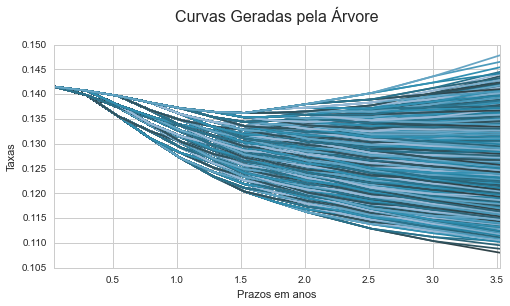

In [74]:
# plota todas as curva geradas
df_curves = pd.DataFrame(d_rtn)
ax1 = df_curves.T.plot(legend=False)
ax1.set_xlabel('Prazos em anos')
ax1.set_ylabel('Taxas')
ax1.set_title(u'Curvas Geradas pela Árvore\n', fontsize=16);

Agora, comparando a média de todas as curvas geradas com os preços de mercado, temos:

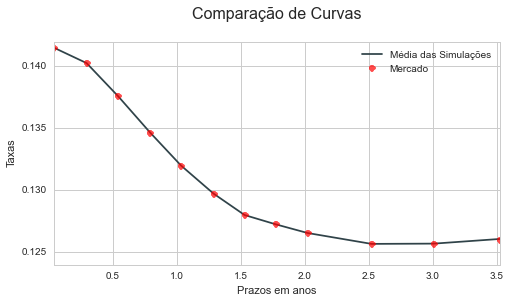

In [75]:
# compara curva media e curva de mercado
df_plot = pd.DataFrame(df_curves.mean())
df_plot.columns = [u"Média das Simulações"]
ax = df_plot.plot()
df_plot = pd.DataFrame(l_txindicativa, index=[x/252. for x in l_prazo])
df_plot.columns = ["Mercado"]
df_plot.plot(style='ro', alpha = 0.7, ax=ax)
ax.set_title(u"Comparação de Curvas\n", fontsize=16)
ax.set_xlabel('Prazos em anos')
ax.set_ylabel('Taxas');

Por fim, ainda podemos visualizar todas os preços possíveis para o bond do último vértice. A distribuição é centrada no preço de mercado do bond, por construção.

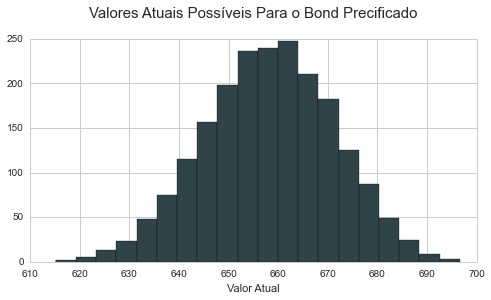

In [76]:
ax = df.hist(bins=20)
ax.set_xlabel("Valor Atual")
ax.set_title(u"Valores Atuais Possíveis Para o Bond Precificado\n", fontsize=15);

O curioso é que com apenas $91$ nós criados ao longo da árvore, é possível se obter o mesmo preço gerado com os $2048$ caminhos criados.

## 3. Aplicação do Modelo

Nesta seção iremos ajustar a volatilidade do modelo e usar a curva criada para precificar diversos instrumentos.

### 3.1. A importância da Volatilidade

A volatilidade é o único parâmetro do modelo e se refere ao $\sigma$ da taxa *forward* de 1 ano. Para demonstrar sua importância, abaixo iremos plotar a distribuição dos valores encontrados para cada caminho do último vértice da curva. Vamos calcular a distribuição para os $\sigma=\{2\%, 5\%, 10\%, 25\%, 50\%, 95\%\}$. Assim, primeiro vamos calcular as médias da distribuição.

In [157]:
# TODO: criar dispersão para diferentes volatilidades. mostrar que eh importante ter
# uma estimacaso crivel dela
#cria arvore
import binomial_tree; reload(binomial_tree)
d_vals = {}
bond_example = instruments.Bond(f_face_value=1000., f_cupon=0.)
for f_sig in [0.02, 0.05, 0.1, 0.25, 0.5, 0.95]:
    my_tree.fit_foward_curve(f_sigma=f_sig, f_faceval=1000.)
    df = bond_example.get_range_of_values(my_tree, i_steps=12)
    d_vals[f_sig] = list(df.values)

In [158]:
df_sig = pd.DataFrame(d_vals)
df_sig.mean()

0.02    658.236155
0.05    658.236155
0.10    658.236155
0.25    658.236153
0.50    658.236148
0.95    658.236122
dtype: float64

Como esperado, são todas "iguais". Agora, vamos plotar o histograma de cada uma das distribuições. Observe que o range de valores do eixo X aumenta em cada gráfico, além da média ficar cada vez mais deslocada para direita.

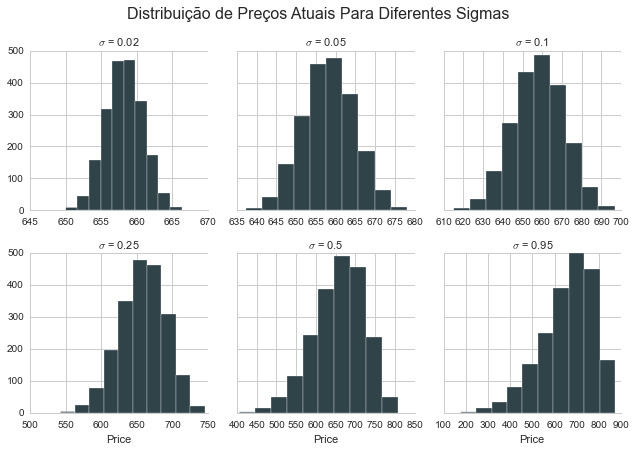

In [161]:
df2 = df_sig.stack().reset_index()
df2.columns = ["index", "$\sigma$", u"Price"]
g = sns.FacetGrid(df2, col="$\sigma$", col_wrap=3, margin_titles=True,
                  sharex=False, sharey=True, size=3)
g.map(plt.hist, 'Price', edgecolor='white')
g.fig.suptitle(u"Distribuição de Preços Atuais Para Diferentes Sigmas",
               fontsize=16, y=1.04);

Para resaltar a disperssão para cada um dos sigmas, abaixo vamos plotar a descrição deste dados.

In [163]:
df3 = df2.copy()
df3.drop("index", axis=1, inplace=True)
df3.Price = ((1000./df3.Price)**(1/(l_prazo[-1]/252.)) - 1) * 100.
df_stat = df3.groupby("$\sigma$").describe().unstack().T
df_stat

$\sigma$            0.02         0.05         0.10         0.25         0.50  \
Price count  2048.000000  2048.000000  2048.000000  2048.000000  2048.000000   
      mean     12.600822    12.602511    12.608550    12.651168    12.808162   
      std       0.126563     0.316510     0.633743     1.597096     3.287308   
      min      12.212594    11.658470    10.804274     8.690043     6.281002   
      25%      12.512740    12.380292    12.158345    11.491909    10.397421   
      50%      12.599974    12.597249    12.587588    12.522114    12.305924   
      75%      12.688215    12.819759    13.036637    13.676681    14.669622   
      max      13.003875    13.639262    14.784376    18.965234    29.174831   

$\sigma$            0.95  
Price count  2048.000000  
      mean     13.409541  
      std       6.905992  
      min       3.958541  
      25%       8.570103  
      50%      11.660371  
      75%      16.249875  
      max      63.345630

### 3.2. Ajustando a Volatilidade

Para estimar a volatilidade, vamos calcular a volatilidade diária da primeira diferença da taxa *forward* entre os DIs com maior liquidez, que são os contratos com vencimento em janeiro de 2017 e 2018. Esta volatilidade será anualizada para 1 ano. Vamos pegar a curva ao meio dia dos últimos três meses para realizar os cálculos. Assim, primeiro vamos calcular as taxas forwards anualizadas e filtrar apenas o horário desejado. Os forwards vão ser calculados da seguinte maneira:

$r_{forward}=\frac{PU_{c}}{PU_{l}}^{252/(DU_{l}-DU_{c})}-1$

Onde $c$ se refere à taxa curta e $l$ à taxa longa.

In [4]:
import pandas as pd

In [5]:
df_di_prices = pd.read_csv("di_fut_price.tsv", index_col="DATE", parse_dates="DATE")
df_di_du = pd.read_csv("di_fut_maturity.tsv", index_col="DATE", parse_dates="DATE")

In [11]:
df_di_prices.ix[:, ['DI1F17', 'DI1F18']].head()

,DI1F17,DI1F18
DATE,,
2016-04-04 09:20:00,13.74,13.47
2016-04-04 09:25:00,13.75,13.48
2016-04-04 09:30:00,13.77,13.51
2016-04-04 09:35:00,13.77,13.53
2016-04-04 09:40:00,13.79,13.56


In [47]:
# calcula partes da formula
df_pu = df_di_prices.ix[:, ['DI1F17', 'DI1F18']]
df_du = df_di_du.ix[:, ['DI1F17', 'DI1F18']]
df_prazo_norm = 252./(df_du['DI1F18']-df_du['DI1F17'])
df_pu = df_pu/100. + 1
df_pu = 10**5/(df_pu)**(df_du/252.)
# calcula taxa forward
df_fwrd = (df_pu['DI1F17']/df_pu['DI1F18'])**df_prazo_norm-1
# cria lista de filtros da taxa
l_filtros_meio_dia = [(x.hour==12)&(x.minute==0)&(x.second==0) for x in df_fwrd.index]
# filtra dados
df_fwrd = df_fwrd[l_filtros_meio_dia]
df_fwrd.head()

DATE
2016-04-04 12:00:00    0.134209
2016-04-05 12:00:00    0.135644
2016-04-06 12:00:00    0.135500
2016-04-07 12:00:00    0.136704
2016-04-08 12:00:00    0.134342
dtype: float64

In [51]:
print "Quantidade de pontos faltantes de {}: {}".format(df_fwrd.shape[0], df_fwrd.isnull().sum())

Quantidade de pontos faltantes de 55: 4


Vamos tirar estes pontos da série. Provavelmente seria mais apropriado usar alguma interpolação entre eles

In [53]:
df_fwrd.dropna(inplace=True)
print "Quantidade de pontos faltantes de {}: {}".format(df_fwrd.shape[0], df_fwrd.isnull().sum())

Quantidade de pontos faltantes de 51: 0


Agora, vamos calcular a dispersão da [primeira diferença](https://en.wikipedia.org/wiki/First-difference_estimator) da taxa forward

In [89]:
df_first_difference = (df_fwrd - df_fwrd.shift())

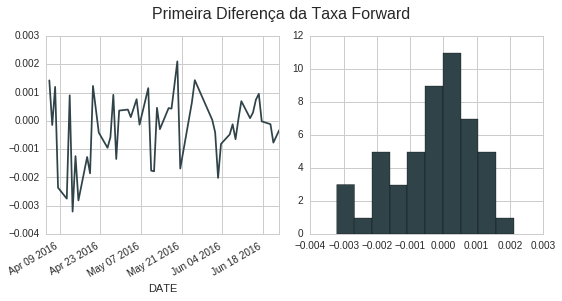

In [90]:
f, (ax1, ax2) = plt.subplots(1, 2)
df_first_difference.plot(ax=ax1)
df_first_difference.hist(ax=ax2);
plt.suptitle(u'Primeira Diferença da Taxa Forward\n', fontsize=16, y=1.04);
f.tight_layout()

In [94]:
# calcula a volatilidade anualizada
f_sigma = df_first_difference.std() * (252.)**.5
print "A vol anualizada do forward de 1 ano entre o DI1F17 e DI1F18 foi de {:01.2f}%".format(f_sigma*100)

A vol anualizada do forward de 1 ano entre o DI1F17 e DI1F18 foi de 1.92%


Olhando assim parece baixa a volatilidade encontrada. Vamos calcular a estrutura inteira

In [136]:
def cal_col(df_di1, df_du, s_short, s_long):
    '''
    Return anuallized volatility of forward rate using daily data
    '''
    # calcula partes da formula
    df_pu = df_di1.ix[:, [s_short, s_long]]
    df_du = df_du.ix[:, [s_short, s_long]]
    df_prazo_norm = 252./(df_du[s_long]-df_du[s_short])
    df_pu = df_pu/100. + 1
    df_pu = 10**5/(df_pu)**(df_du/252.)
    # calcula taxa forward
    df_fwrd = (df_pu[s_short]/df_pu[s_long])**df_prazo_norm-1
    # cria lista de filtros da taxa
    l_filtros_meio_dia = [(x.hour==12)&(x.minute==0)&(x.second==0)
                          for x in df_fwrd.index]
    df_fwrd = df_fwrd[l_filtros_meio_dia]
    df_first_difference = (df_fwrd - df_fwrd.shift())
    f_sigma = df_first_difference.std() * (252.)**.5
    return f_sigma

In [137]:
l_col = [u'DI1F17', u'DI1F18', u'DI1F19', u'DI1F20', u'DI1F21',
         u'DI1F22', u'DI1F23', u'DI1F24', u'DI1F25', u'DI1F26',
         u'DI1F27']
l_sigma = []
l_leg = []
for idx in xrange(len(l_col)-1):
    f_sigma = cal_col(df_di_prices, df_di_du, l_col[idx], l_col[idx+1])
    l_leg.append("{}-{}".format(l_col[idx][3:], l_col[idx+1][3:]))
    l_sigma.append(f_sigma)

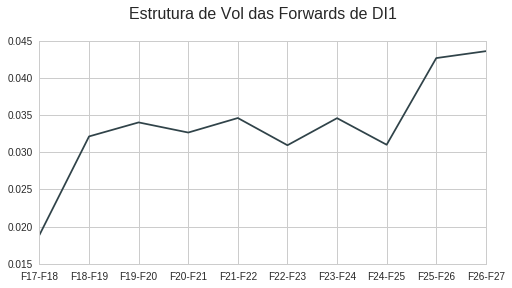

In [145]:
ax = pd.DataFrame(l_sigma, index=l_leg).plot(legend=False);
ax.set_title("Estrutura de Vol das Forwards de DI1\n", fontsize=16);

Como pode ser visto, a volatilidade das forwards fico em um mesmo nível por vários vencimentos. Vamos utilizar a média das volatilidades destes vértices como a volatilidade da modelo daqui para frente

In [144]:
f_sigma = np.mean(l_sigma[1:-2])
print u"A volatilidade utilizada será de {:0.2f}%".format(f_sigma*100)

A volatilidade utilizada será de 3.28%


### 3.3. Precificando Borboletas de DI1

A estratégia de borboleta no mercado de Juros Futuro (DI1) consistem em combinar três vencimentos diferentes de maneira a se proteger de movimentos paralelos na curva de juros. Apesar de existir muitas maneiras de se [balancear](http://www.jamesgoulding.com/Research_II/Butterfly/Butterfly%20%28Understanding%29.pdf) esta estratégia para privilegiar movimentos específicos da curva, os preços são calculados sempre da mesma maneira pelo mercado. Basicamente é uma diferença de taxas forwards, cotada em *basispoints*. Assim, o preço é dado por:

$P_{fly} = \left (  \left (PU_{m}/PU_{l}\right )^{252/(DU_{l}-DU_{m})} / \left (PU_{c}/PU_{m}\right )^{252/(DU_{m}-DU_{c})} \right ) \times 10^{\,4}$

Onde $c$ é a taxa curta, $l$ a longa e $m$ a taxa do miolo. Agora, vamos supor que nós confiamos nos preços dos contatos com vencimento $F$ (janeiro) e queremos saber se o preço da borboleta $F17-N17-F18$ (janeiro, julho, janeiro) está em um preço razoável. Vamos supor também que começamos o dia às 10:00 e fixamos a curva neste ponto. Então, utilizando apenas as $F$ e a volatilidade acima minha treliça ficaria da seguinte maneira:

In [ ]:
df_di_prices = pd.read_csv("di_fut_price.tsv", index_col="DATE", parse_dates="DATE")
df_di_du = pd.read_csv("di_fut_maturity.tsv", index_col="DATE", parse_dates="DATE")

In [150]:
l_filtros_cinco_maio = [(x.day==5)&(x.month==5)&(x.hour>=10)&(x.hour<=15) for x in df_di_prices.index]

In [166]:
df_maio_di = df_di_prices[l_filtros_cinco_maio]
df_maio_du = df_di_du[l_filtros_cinco_maio]
l_col = [u'DI1F17', u'DI1F18', u'DI1F19', u'DI1F20', u'DI1F21',
         u'DI1F22', u'DI1F23', u'DI1F24', u'DI1F25']

In [177]:
#pontos utilizados
l_tx_di= list((df_maio_di[l_col].head(1)/100.).values[0])
l_du_di= list((df_maio_du[l_col].head(1)/252).values[0])

In [181]:
import binomial_tree
my_tree = binomial_tree.KWFTreePU(l_tx_di, l_du_di)
my_tree.fit_foward_curve(f_sigma=f_sigma, f_faceval=100000.)

In [191]:
#cria arvore e calcula taxas
import instruments
bond_example = instruments.Bond(f_face_value=100000., f_cupon=0.)
d_rtn = {}
for i in xrange(1, len(l_du_di) + 1):
    df_aux = bond_example.get_range_of_values(my_tree, i_steps=i)
    f_time = l_du_di[i-1]
    df_aux = (100000./df_aux) ** (1./ f_time) - 1
    d_rtn[f_time] = list(df_aux.values)

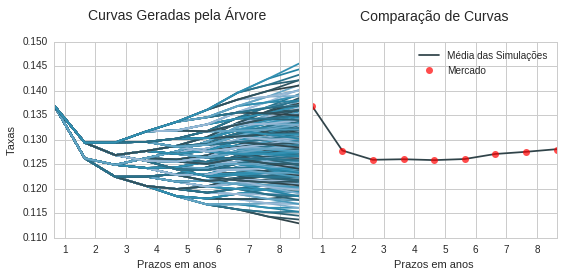

In [199]:
f, (ax1, ax2) = plt.subplots(1, 2,sharey=True, sharex=True)
# plota todas as curva geradas
df_curves = pd.DataFrame(d_rtn)
ax1 = df_curves.T.plot(legend=False, ax = ax1)
ax1.set_xlabel('Prazos em anos')
ax1.set_ylabel('Taxas')
ax1.set_title(u'Curvas Geradas pela Árvore\n', fontsize=14);

# compara curva media e curva de mercado
df_plot = pd.DataFrame(df_curves.mean())
df_plot.columns = [u"Média das Simulações"]
df_plot.plot(ax=ax2)
df_plot = pd.DataFrame(l_tx_di, index=l_du_di)
df_plot.columns = ["Mercado"]
df_plot.plot(style='ro', alpha = 0.7, ax=ax2)
ax2.set_title(u"Comparação de Curvas\n", fontsize=14)
ax2.set_xlabel('Prazos em anos')
ax2.set_ylabel('Taxas');

f.tight_layout()

Agora vamos calcular os preços da estratégia com os dados de mercado deste dia

In [205]:
#pontos utilizados
l_fnf = [u'DI1F17', u'DI1N17', u'DI1F18']
df_fnf = df_maio_di[l_fnf]
df_fnf_du =  df_maio_du[l_fnf]

In [210]:
def calc_forward(l_fnf):
    '''
    Calculate the foward rate
    '''
    df_fnf = df_maio_di[l_fnf]
    df_fnf_du =  df_maio_du[l_fnf]

    # calcula partes da formula
    df_prazo_norm = 252./(df_fnf_du[l_fnf[0]]-df_fnf_du[l_fnf[1]])
    df_pu = df_fnf/100. + 1
    df_pu = 10**5/(df_pu)**(df_fnf_du/252.)
    # calcula taxa forward
    df_fwrd1 = (df_pu[l_fnf[0]]/df_pu[l_fnf[1]])**df_prazo_norm-1
    return df_fwrd1

In [215]:
df_fly = (calc_forward([u'DI1N17', u'DI1F18']) - calc_forward([u'DI1F17', u'DI1N17']))*10**4

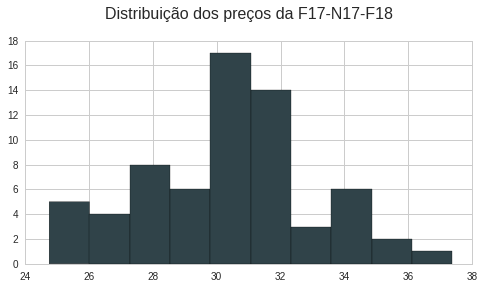

In [226]:
ax = df_fly.hist()
ax.set_title(u"Distribuição dos preços da F17-N17-F18\n", fontsize=16);

Ótimo, agora vamos comparar esta distribuição de preços com os preços gerados pelo modelo. O problema aqui é que precisamos de um vencimento que está fora da discretização da árvore. Como a estrutura do modelo impõe que as taxas forwards sejam constantes entre os nós dela, podemos procurar o primeiro nó com vencimento depois do que queremos e começar o cálculo do passo anterior, como em uma interpolação. A única mudança necessária é que no primeiro passo da precificação (de trás para frente), precisamos descontar apenas pelo prazo entre o nó encontrado e o instrumento desejado.

### 3.3. Precificando Bla

## 4. Conclusão

bla bla

O modelo poderia ser utilizado de maneira relevatnte para tomada de decisão em trade, desde que se achasse outro método para criar uma curva crível.  



## 5. Últimas Considerações

bla bla

Talvez se não mantesse todos os nós em memória fosse uma boa. Também criei todos os caminhos na força bruta, mas isso é inviável. Seria melhor criar a distrinuiçao ponderando cada valor pela respectiva probabilidade e criando uma distribuição hipotética

#### TODO:
- Implementar (OK)
- Levantar os preços histórico dos títulos: NTB (OK)
- Apresentar os principais pontos da abordagem (hipóteses, limitações e etc) (falta limitações)
- detalhar o processo de calibração (juros e vol) (OK)
- Detalhar a determiação dos parâmetros do modelo ($\sigma$) (OK)
- Checar se tem base de dados de opções (Call Européia) de Juros
- Demonstrar a precificação de 2 derivativos mais complexos (opcional compara com mercado)


*Style notebook and change matplotlib defaults*

In [1]:
#loading style sheet
from IPython.core.display import HTML
HTML(open('ipython_style.css').read())

In [2]:
#changing matplotlib defaults
%matplotlib inline
import seaborn as sns
sns.set_palette("deep", desat=.6)
sns.set_context(rc={"figure.figsize": (8, 4)})
sns.set_style("whitegrid")
sns.set_palette(sns.color_palette("PuBuGn_d", 10))